## Generate Ratings

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os, sys
ROOT = os.path.abspath("..")
sys.path.insert(0, ROOT)

from rich import print
from tqdm import tqdm

from src.utils.trad_metrics import TradMetrics
from lang_datasets.scripts.constants import LANGUAGES

In [2]:
trad_metrics = TradMetrics()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/Users/yixiantan/opt/miniconda3/envs/omscs-llm/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [3]:
RATINGS_FILE = "../ratings/flores200-ratings.json"
TRANSLATIONS_FILE = "../lang_datasets/sample_dataset/flores_sample_translations.json"

CANDIDATE_MAP = {
    "candidate_1": "google_translate",
    "candidate_2": "nllb_translate",
    "candidate_3": "llm_translate",
}

with open(RATINGS_FILE, "r", encoding="utf-8") as f:
    ratings = json.load(f)

with open(TRANSLATIONS_FILE, "r", encoding="utf-8") as f:
    translations = json.load(f)

In [4]:
# Per language model rating
def get_candidate_ratings(candidate_id, languages):

    candidate_ratings = {
        candidate_id: {
            language: {
                "sentence_bleu": {"scores": [], "avg": None},
                "chrf": {"scores": [], "avg": None},
                "comet": {"scores": [], "avg": None},
            }
            for language in languages
        }
    }

    for data in tqdm(ratings):
        curr_lang = data["language_code"]
        source_sentence = data["source_sentence"]
        reference_sentence = data["original_english_text"]
        for candidate in data["candidate_sentence_evaluations"]:
            if candidate["candidate_id"] != candidate_id:
                continue

            candidate_sentence = candidate["candidate_sentence"]
            review_all_scores = trad_metrics.review_all_models(
                [candidate_sentence], reference_sentence, source_sentence
            )

        # Append the scores to the candidate ratings
        candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["scores"].append(
            {
                "score": review_all_scores["sentence_bleu"][0],
                "translation": candidate_sentence,
            }
        )
        candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"].append(
            {"score": review_all_scores["chrf"][0], "translation": candidate_sentence}
        )
        candidate_ratings[candidate_id][curr_lang]["comet"]["scores"].append(
            {"score": review_all_scores["comet"][0], "translation": candidate_sentence}
        )

        # Update the average scores
        curr_bleu_score_sum = sum(
            score["score"]
            for score in candidate_ratings[candidate_id][curr_lang]["sentence_bleu"][
                "scores"
            ]
        )
        curr_chrf_score_sum = sum(
            score["score"]
            for score in candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"]
        )
        curr_comet_score_sum = sum(
            score["score"]
            for score in candidate_ratings[candidate_id][curr_lang]["comet"]["scores"]
        )

        candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["avg"] = (
            curr_bleu_score_sum
            / len(candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["scores"])
        )
        candidate_ratings[candidate_id][curr_lang]["chrf"]["avg"] = (
            curr_chrf_score_sum
            / len(candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"])
        )
        candidate_ratings[candidate_id][curr_lang]["comet"]["avg"] = (
            curr_comet_score_sum
            / len(candidate_ratings[candidate_id][curr_lang]["comet"]["scores"])
        )

    return candidate_ratings

In [6]:
OUTPUT_PATH = "../ratings/"
cands_output_files = ["google_ratings.json", "nllb_ratings.json", "llm_ratings.json", "alt_bench_ratings.json"]

In [7]:
def generate_ratings(): 
    for cands_output_file in cands_output_files:
        file_output_path = os.path.join(OUTPUT_PATH, cands_output_file)

        # As long as the output file does not exist, we will write the ratings to the file
        if not os.path.exists(file_output_path):

            print(f"{cands_output_file} does not exist, generating ratings for all...")

            google_trans_ratings = get_candidate_ratings("candidate_1", LANGUAGES.keys())
            nllb_trans_ratings = get_candidate_ratings("candidate_2", LANGUAGES.keys()) 
            llm_trans_ratings = get_candidate_ratings("candidate_3", LANGUAGES.keys())

            with open(os.path.join(f"{OUTPUT_PATH}/google_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(google_trans_ratings, f, indent=4, ensure_ascii=False)

            with open(os.path.join(f"{OUTPUT_PATH}/nllb_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(nllb_trans_ratings, f, indent=4, ensure_ascii=False)

            with open(os.path.join(f"{OUTPUT_PATH}/llm_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(llm_trans_ratings, f, indent=4, ensure_ascii=False)

            # with open(os.path.join(f"{OUTPUT_PATH}/alt_bench_ratings.json"), "w", encoding="utf-8") as f:
            #     json.dump(alt_bench_ratings, f, indent=4, ensure_ascii=False)
            
            return
    
    print("All ratings files already exist, skipping generation...")

generate_ratings()

All ratings files already exist, skipping generation...

## Data Analysis on Ratings

In [29]:
%load_ext autoreload
%autoreload 2

import json
import os, sys
ROOT = os.path.abspath("..")
sys.path.insert(0, ROOT)

from rich import print
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from src.utils.trad_metrics import TradMetrics
from src.utils.plot_utils import plot_ratings_graph
from lang_datasets.scripts.constants import LANGUAGES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
OUTPUT_PATH = "../ratings/"
cands_output_files = ["google_ratings.json", "nllb_ratings.json", "llm_ratings.json", "alt_bench_ratings.json"]

In [31]:
# Read Google ratings
with open(os.path.join(OUTPUT_PATH, "google_ratings.json"), "r", encoding="utf-8") as f:
    google_trans_ratings = json.load(f)

# Read NLLB ratings
with open(os.path.join(OUTPUT_PATH, "nllb_ratings.json"), "r", encoding="utf-8") as f:
    nllb_trans_ratings = json.load(f)

# Read LLM ratings
with open(os.path.join(OUTPUT_PATH, "llm_ratings.json"), "r", encoding="utf-8") as f:
    llm_trans_ratings = json.load(f)

all_ratings = [google_trans_ratings, nllb_trans_ratings, llm_trans_ratings]

In [47]:
rating_rows = []

CANDIDATE_MAP = {
    "candidate_1": "Google",
    "candidate_2": "NLLB",
    "candidate_3": "LLM",
}

for rating in all_ratings:
    for candidate_id, candidate_ratings in rating.items():
        for language, scores in candidate_ratings.items():
            rating_rows.append({
                "candidate": CANDIDATE_MAP[candidate_id],
                "language": language,
                "sentence_bleu": scores["sentence_bleu"]["avg"],
                "cHRF": scores["chrf"]["avg"],
                "COMET": scores["comet"]["avg"] * 100
            })

ratings_df = pd.DataFrame(rating_rows)

In [55]:
ratings_df

,candidate,language,sentence_bleu,cHRF,COMET
0,Google,zho_Hans,27.672341,59.445611,87.789173
1,Google,jpn_Jpan,24.389940,58.186243,87.341276
2,Google,vie_Latn,26.546916,59.372441,85.863124
3,Google,ind_Latn,31.176224,62.455693,86.789033
4,Google,tgl_Latn,31.761858,61.530642,80.505257
5,Google,tha_Thai,20.699371,52.486669,82.208694
6,Google,tso_Latn,19.777173,44.291044,62.172357
7,Google,amh_Ethi,18.483543,45.755685,72.503600
8,NLLB,zho_Hans,29.832641,59.151134,85.840250
9,NLLB,jpn_Jpan,26.578028,57.054340,87.047343


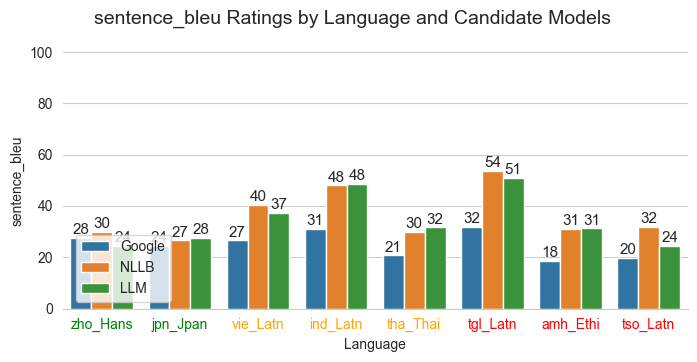

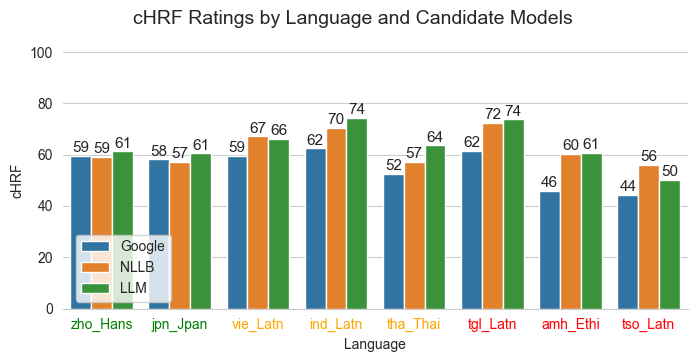

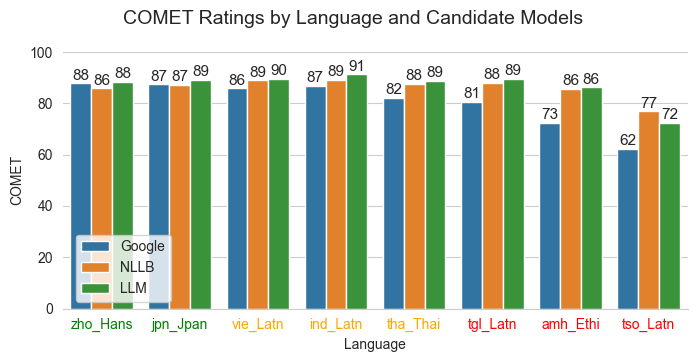

In [58]:
plot_ratings_graph(ratings_df, x="language", y="sentence_bleu")
plot_ratings_graph(ratings_df, x="language", y="cHRF", save_path="../images/chrf_scores.png")
plot_ratings_graph(ratings_df, x="language", y="COMET", save_path="../images/comet_scores.png")